## Description of the AB Test

* Channel KLMN runs a TV commercial featuring the Mayor of Los Angeles nationwide to promote its political talk show "US Politics This Week" and it is found this commercial only works for people residing in Los Angeles. 
* The Executive Producer of “US Politics This Week” suggested to add commercials featuring Mayors of local cities to the existing TV commercial (featuring the Mayor of Los Angeles).
* After launching the new commercials, along with the old commercial, an AB Test found that: a lower fraction of people who saw the new commercials watched “US Politics This Week” as compared to people who saw the old commercial.

## Guidelines

* Reproduce the negative result found above. Is it actually negative?
* Explain what might be happening. Are the commercials with local Mayors really driving a lower fraction of people to watch the show?
* If you found something wrong with the experiment, design an algorithm that returns FALSE if the problem happens again in the future. If you didn’t find anything wrong, what is your recommendation to the Executive Producer regarding whether or not they should continue airing the new commercials?

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import scipy
from scipy import stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

from statsmodels.stats import proportion
from statsmodels.stats.proportion import proportions_ztest

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

plt.rc('figure', figsize=(3.0, 3.0))

### 1. Read Data

In [2]:
viewer_data = pd.read_csv("../dataset/viewer_data.csv")
test_data = pd.read_csv("../dataset/test_data.csv", parse_dates=["date"])

In [3]:
viewer_data.head()

,viewer_id,gender,age,city
0,1918165,Female,39,Dallas
1,27662619,Female,28,New York
2,5493662,Female,53,Detroit
3,14441247,Male,41,New York
4,25595927,Male,53,Seattle


In [4]:
test_data.head()

,viewer_id,date,tv_make,tv_size,uhd_capable,tv_provider,total_time_watched,watched,test
0,24726768,2018-01-16,Sony,70,0,Comcast,10.75,0,1
1,25001464,2018-01-18,Sony,32,0,NaN,2.75,0,0
2,28291998,2018-01-18,Sony,50,1,Dish Network,20.00,0,0
3,17057157,2018-01-19,Sony,32,0,Comcast,1.50,0,0
4,29504447,2018-01-17,Sony,32,0,Comcast,17.50,0,0


### 2. Exploratory Data Analysis (EDA)

In [7]:
# pp.ProfileReport(viewer_data)

In [8]:
# pp.ProfileReport(test_data[test_data.columns[1:]])

### 3. Investigation of the AB Test.

####  Part 1. Reproduce the Negative Result Found in the AB Test.

In [55]:
merged = pd.merge(test_data, viewer_data, on="viewer_id")
merged.head(2)

,viewer_id,date,tv_make,tv_size,uhd_capable,tv_provider,total_time_watched,watched,test,gender,age,city
0,24726768,2018-01-16,Sony,70,0,Comcast,10.75,0,1,Male,52,Boston
1,25001464,2018-01-18,Sony,32,0,NaN,2.75,0,0,Male,38,New York


In [56]:
#  two-sample z-test of proportions:
n1 = merged[merged.test == 1].shape[0] # number of commercial viewers in experiment group
n2 = merged[merged.test == 0].shape[0] # number of commercial viewers in control group
p1 = merged[merged.test == 1].watched.sum() / n1 # proportion of show watchers in experiment group
p2 = merged[merged.test == 0].watched.sum() / n2 # proportion of show watchers in control group

p_pool = merged.watched.sum() / (n1 + n1) # pooled propportion of show watchers
print(n1, n2, p1, p2, p_pool)

204327 213143 0.04577955923593064 0.06309379149209686 0.05579781428788168


In [57]:
z = (p1 - p2) / np.sqrt(p_pool * (1 - p_pool) * (1 / n1 + 1 / n2))
p_value = stats.norm.cdf(z) * 2
print("z statistic: {0:.6f}".format(z))
print("p value: {0:.6E}".format(p_value))

z statistic: -24.363963
p value: 4.123635E-131


Above is the reprodduction of the AB test. Since z = -24.36 < 0 and p_value << 0.05, the AB test result shows the experiment group (the audience who viewed the new commercials involving local Mayors) has a statistically significantly smaller proportion of commercial viewers that susequently watched the show.

#### Part 2. Explain what might be happening

Now we do AB test for each city, except Los Angeles (this is because all viewers in the Los Angeles can only be categorized into the control group). And the z-satistic of the proportion test as well as the corresponding p value will be presented for each city.

In [113]:
def two_sample_z_test(df):
    n1 = df[df.test == 1].shape[0] 
    n2 = df[df.test == 0].shape[0] 
    p1 = df[df.test == 1].watched.sum() / n1 
    p2 = df[df.test == 0].watched.sum() / n2 
    p_pool = df.watched.sum() / (n1 + n1) 

    z = (p1 - p2) / np.sqrt(p_pool * (1 - p_pool) * (1 / n1 + 1 / n2))
    p_value = stats.norm.cdf(z) * 2 if z < 0 else (1-stats.norm.cdf(z)) * 2
    s = pd.Series([ p_pool, z, p_value], index=["p_pool","z_statistic", "p_value"])
    return s

In [114]:
res = merged[merged.city!="Los Angeles"].groupby("city").apply(two_sample_z_test)

In [116]:
res[["z_statistic", "p_value"]]

,z_statistic,p_value
city,,
Atlanta,0.237036,0.812629
Boston,0.299507,0.764553
Chicago,0.930993,0.351857
Dallas,-1.178892,0.238441
Detroit,1.949756,0.051205
Houston,0.441955,0.658522
Miami,0.782176,0.434111
Minneapolis,-0.208516,0.834826
New York,-1.837328,0.066162


Interestingly, the individual AB tests show no significant difference in watching rate (proportion of commercial vieweres who will end up watching the tv show) in any of the cities. 

In [69]:
test_group = merged[merged.test == 1]
control_group = merged[merged.test == 0]
test_group.head(1)

,viewer_id,date,tv_make,tv_size,uhd_capable,tv_provider,total_time_watched,watched,test,gender,age,city
0,24726768,2018-01-16,Sony,70,0,Comcast,10.75,0,1,Male,52,Boston


In [151]:
# In below, I use "views" and "number of observations" interchangeably.
test_cnt = test_group.groupby('city').size()
df1 = test_cnt / test_group.shape[0]
control_cnt = control_group.groupby('city').size()
df2 = control_cnt / control_group.shape[0]
nobs = pd.concat([test_cnt, control_cnt, df1, df2], axis=1)
nobs.columns = ["test_city_views", "control_city_views", "prop_to_test_views", "prop_to_control_views"]
nobs = nobs.fillna(0).round(4)
nobs.test_city_views = nobs.test_city_views.astype(int)
nobs["diff"] = nobs.prop_to_test_views - nobs.prop_to_control_views
p_pool = pd.DataFrame({"p_pool":merged.groupby("city").apply(lambda df: df.watched.sum() / df.shape[0])})
nobs = nobs.join(p_pool)

In [157]:
nobs.sort_values("p_pool")

,test_city_views,control_city_views,prop_to_test_views,prop_to_control_views,diff,p_pool
Philadelphia,24495,4261,0.1199,0.0200,0.0999,0.023473
Seattle,15850,2846,0.0776,0.0134,0.0642,0.026048
Dallas,13807,12874,0.0676,0.0604,0.0072,0.049286
San Francisco,12609,11691,0.0617,0.0549,0.0068,0.049794
Detroit,9192,8739,0.0450,0.0410,0.0040,0.050137
Atlanta,12599,11728,0.0617,0.0550,0.0067,0.050561
Chicago,16991,16054,0.0832,0.0753,0.0079,0.050598
Miami,8984,8301,0.0440,0.0389,0.0051,0.050969
Tampa,9631,8974,0.0471,0.0421,0.0050,0.051492
New York,35812,34082,0.1753,0.1599,0.0154,0.051492


In [250]:
nobs.test_city_views - nobs.control_city_views

Atlanta            871
Boston             902
Chicago            937
Dallas             933
Detroit            453
Houston            787
Miami              683
Minneapolis        890
New York          1730
Philadelphia     20234
Phoenix            698
San Francisco      918
Seattle          13004
Tampa              657
Los Angeles     -52513
dtype: int64

The above shows that the number of observations in test and control groups are highly unbalanced given each city (except Los Angeles, all other cities are having more observations in the control group than the observations in the test group). It seems this is a consequence of the erroneous data collection process aming to balance the total number of observations in the test and control groups!

From another perspective, we can see that the distribution of views (by city) are drastically differerent between the test and control groups (see column "prop_to_test_views" and "prop_to_control_views"). In the test group, views are spread in the non-Los-Angeles cities where pooled watching rate are low (ranging from 0.023 to 0.053) and no view is present in Los Angeles; whereas in the control group, 24.64% views are from Los Angeles where the pooled watching rate is as high as 0.103, and less views are collected from lower watching rate cities. This is the exact setup of Simpson's Paradox! Here, it is the difference in distribution of city_views between the test and control groups, combined with the fact that different cities have different overall watching rates (p_pool, Los Angeles vs others) that drives the misleading AB Test results.

(In order to fix the above issue, we should first make sure the views or the viewers are balanced on all levels of all charateristics)

At this stage, I suggest only trust the city-wise AB test results, which means, we found no enough evidence for any of the investigated city to conclude that the new commercial can help to change the watching rate.

<IPython.core.display.Javascript object>


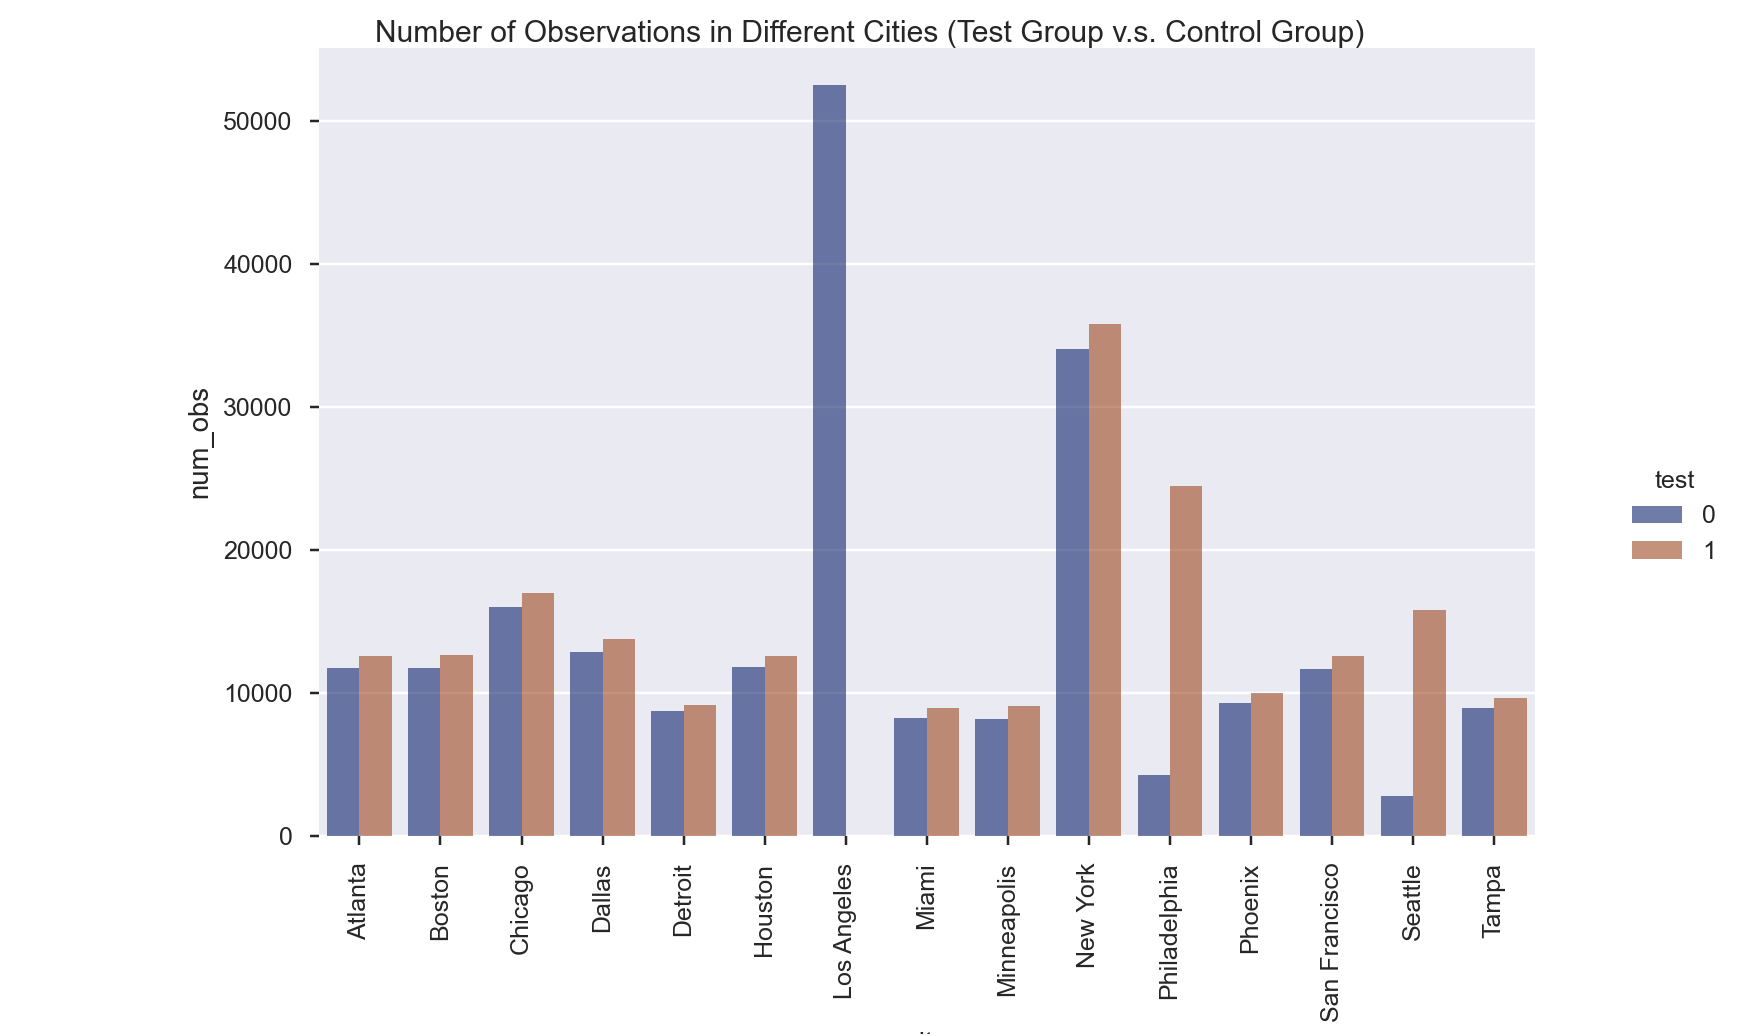

[Text(0, 0, 'Atlanta'),
 Text(1, 0, 'Boston'),
 Text(2, 0, 'Chicago'),
 Text(3, 0, 'Dallas'),
 Text(4, 0, 'Detroit'),
 Text(5, 0, 'Houston'),
 Text(6, 0, 'Los Angeles'),
 Text(7, 0, 'Miami'),
 Text(8, 0, 'Minneapolis'),
 Text(9, 0, 'New York'),
 Text(10, 0, 'Philadelphia'),
 Text(11, 0, 'Phoenix'),
 Text(12, 0, 'San Francisco'),
 Text(13, 0, 'Seattle'),
 Text(14, 0, 'Tampa')]

Text(0.5, 0.98, 'Number of Observations in Different Cities (Test Group v.s. Control Group)')

In [257]:
sizes = pd.DataFrame({"num_obs": merged.groupby(["test", "city"]).size()}).reset_index()

g = sns.catplot(
    data=size1, kind="bar",
    x="city", y="num_obs", hue="test",
    ci="sd", palette="dark", alpha=.6, height=3.2 , aspect=1.5)

for ax in g.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    
g.fig.suptitle("Number of Observations in Different Cities (Test Group v.s. Control Group)")

Given the visualized distribution of views across different cities, the differences of views in Los Angeles (52513 obs in the control group and 0 obs in the test group), Seattle (13004 more obs in the test group) and Philadelphia (20234 more obs in the test group) are quite offending. 

To see if there's any factor other than city will influence the watching rate (the value of watched), we can run a logistic regression model with the "watched" column as the label column and check the coefficient estimation (as well as their test results).

In [162]:
formula = """
watched ~ C(tv_make)+C(tv_size)+C(uhd_capable)+C(tv_provider) + total_time_watched + 
C(test) + C(gender) + age + C(city)
"""
model_fit = smf.glm(formula, merged, family = sm.families.Binomial()).fit()
print(model_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                watched   No. Observations:               364826
Model:                            GLM   Df Residuals:                   364792
Model Family:                Binomial   Df Model:                           33
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -76142.
Date:                Sun, 27 Sep 2020   Deviance:                   1.5228e+05
Time:                        22:25:25   Pearson chi2:                 3.65e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

Note: the fitted model above is a simplified one where only main effects are investigated (no interaction terms considered). The test summary shows no factor other than the Intercept, C(city)[T.Los Angeles], C(city)[T.Philadelphia] and C(city)[T.Seattle] have statistically significant coefficient values (-2.9096, 0.7609, -0.7725, -0.7021). This means:

(1) being a viewer from Los Angeles drives watching rate up; 

(2) being a viewer from Philadelphia & Seattle are drives watching rate down; 

(3) there's no strong enough evidence to show that adding the new commercials featuring local Mayors (see the p value of C(test)[T.1]) can help to change the watching rate. 

#### Part 3. Design an algorithm that returns FALSE if the problem happens again in the future.

Since the experience tells only city is a factor that can influence watching rate, the algorithm required should check if the number of views (sample sizes) in the test and control groups are similar for each city. (If yes, we can at least do the AB test on city level.) There are three test to be done:
(1) One-sample z-test of proportion to see, given sampled data from all cities, if the test group and control group have similar sizes.

(2) Chi-square test of proportion, to test if distribution of views (among cities are different) are different between test group and control groups. 

And False will be returned if any of the test show significant difference between the test and control groups.

In [213]:
class test_data_validity:
    def __init__(self, df):
        self.data = df
        
    def test_of_equal_sizes(self):
        n1 = self.data[self.data.test == 1].shape[0]
        n2 = self.data[self.data.test == 0].shape[0]
        n = n1 + n2
        p = 0.5
        z = (n1 - n * p) / np.sqrt(n * p * (1 - p))
        p = stats.norm.cdf(z) * 2 if z < 0 else (1 - stats.norm.cdf(z)) * 2
        return z, p, False if p < 0.05 else True

    def test_of_same_proportions(self):
        sizes1 = self.data[self.data.test==1].groupby("city").size()
        sizes2 = self.data[self.data.test==0].groupby("city").size()
        obs = pd.concat([sizes1, sizes2], axis=1).dropna().values
        chi2, p, dof, ex = stats.chi2_contingency(obs)
        return z, p, False if p < 0.05 else True
    
    def data_sanity_check_result(self):
        _, _, res1 = self.test_of_equal_sizes()
        _, _, res2 = self.test_of_same_proportions()
        
        if res1 and res2:
            return True
        else:
            return False

In [214]:
t = test_data_validity(merged)

In [215]:
t.test_of_equal_sizes()

(-13.64454146789537, 2.175777393001849e-42, False)

In [216]:
t.test_of_same_proportions()

(-24.36396265268454, 0.0, False)

In [218]:
t.data_sanity_check_result()

False

Data sanity check code usage example:

In [217]:
obj = test_data_validity(merged)
obj.data_sanity_check_result()

False